# Import Depedencies

In [43]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import urllib
import requests
from io import BytesIO


# Image Processing

Define functions that read image with URL, and that get image's tensor.

In [44]:
# Read image using URL
def read_image_from_url(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


# Define image processing function (resize the image to 512*512)
def get_tensor(image_path, img_size=(512, 512)):
    try:
        # Read from URL
        image = read_image_from_url(image_path)
    except ValueError:
        # Read from directory
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image).unsqueeze(0)

    return img_tensor

Load image in local directory

In [45]:
# # Process original image with directory path
# img_path = 'selfie.JPG'
# img_tensor = get_tensor(img_path)
# original_img = cv2.imread(img_path)
# original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert to RGB

Load image with URL

In [46]:
# Process original image with URL (this link is the link to my selfie)
url= "https://drive.google.com/uc?id=1SgSYBYDe9Junk2fr616RT6rs0jLKWj16"
img_tensor = get_tensor(url)

# Show the original image
original_img = read_image_from_url(url)

Resize the orginal image and plot it.

Text(0.5, 1.0, 'Original Image')

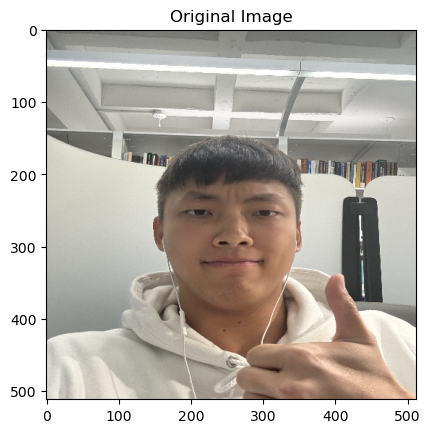

In [47]:
original_img = cv2.resize(original_img, (512, 512))       # resize the original image to 512*512
plt.imshow(original_img)
plt.title("Original Image")

# 3-1: Segment Human from Background

## Load Intended Model
The reason why I chose to use two models from *briaai* (RMBG-1.4 and RMBG-2.0) is beacuse they mentioned background removal in their model description. However, the result of those models didn't work as expected. Therefore, I tried a model from *jonathandinu*, which is made for face segmentation, and it worked perfectly.

### briaai/RMBG-1.4

This model segments human from background with a lot of noise.

In [48]:
from transformers import AutoModelForImageSegmentation
model = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4", trust_remote_code=True)

### **Best Result**: *jonathandinu/face-parsing*

In [49]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

processor = AutoImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")

/opt/homebrew/Caskroom/miniforge/base/envs/DP/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


## Perform segmentation

Get the output of model

In [50]:
# Get the output of pretrained model
model.eval()
with torch.no_grad():
    output = model(img_tensor)

Define a function that get mask from model's ouput tensor

In [51]:
# This function can get the mask with regardless of different datatype output of models (tuple or list)
def get_masks(tensor_from_output):
    # Iterate through each mask
    masks = []
    for i, mask_tensor in enumerate(tensor_from_output ):
        masks.append(mask_tensor.squeeze().cpu().numpy())  # Convert mask to tensor and store it into a list (masks)

    # Stack all class tensors along a new dimension
    stacked_masks = torch.stack([torch.tensor(c) for c in masks], dim=0)

    # Generate the segmentation mask
    segmentation_mask = torch.argmax(stacked_masks.squeeze(), dim=0).cpu().numpy()

    return segmentation_mask

Check the mask's shape

In [52]:
segmentation_mask = get_masks(tensor_from_output=output[0])


print('segmentation mask shape:', segmentation_mask.shape)

segmentation mask shape: (128, 128)


## Visualize the result

In [53]:
# Visualization function
def visualize_mask(org_img, mask_list, num_img, mask_names):

    # Create a list that store all masks
    masks = []
    
    for i in range(num_img-1):
        # Resize the mask to match the dimensions of the original image
        masks.append(cv2.resize(mask_list[i], (org_img.shape[1], org_img.shape[0]), interpolation=cv2.INTER_NEAREST))

    # Visualize image comparing
    plt.figure(figsize=(5*num_img, 5))

    # Show the original image first
    plt.subplot(1, num_img, 1)
    plt.title("Original Image")
    plt.imshow(org_img)

    # Show rest of the images
    for i in range(num_img-1):
        plt.subplot(1, num_img, i+2)
        plt.title(mask_names[i])
        plt.imshow(masks[i])

    plt.show()



def human_segmentation(original_image, segmentation_mask):
    # Ensure the segmentation mask matches the image dimensions
    mask_resized = cv2.resize(segmentation_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Find all values greater than 0 (not background)
    foreground = mask_resized > 0
    foreground = foreground.astype(np.uint8)

    # Create a blank (black:0) background
    background = np.zeros_like(original_image)

    # Set the object region to white (white:255)
    result_image = np.where(foreground[..., None], 255, background)

    return result_image



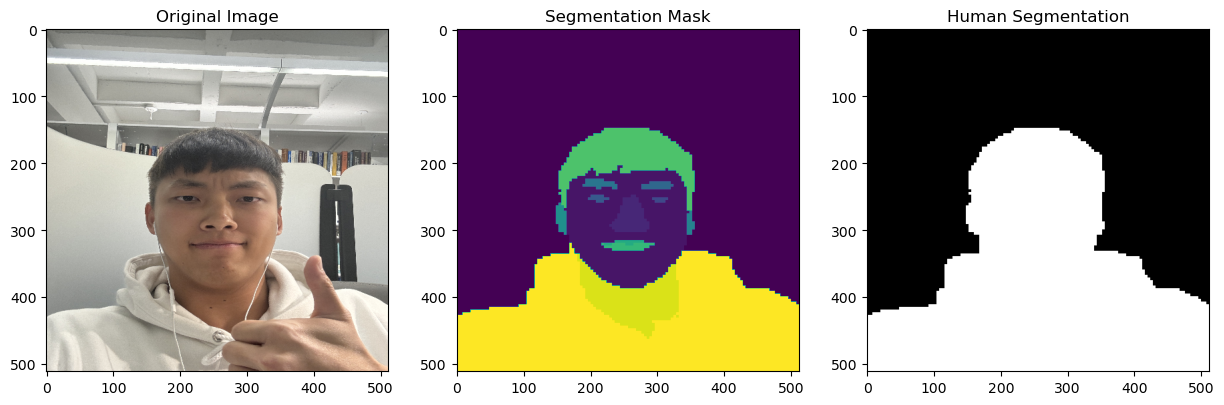

In [54]:
segmentation_masks = [get_masks(tensor_from_output=output[0]), human_segmentation(original_img, segmentation_mask)]

visualize_mask(original_img, segmentation_masks, num_img=3, mask_names=['Segmentation Mask', 'Human Segmentation'])

# 3-2: Add in Gaussian Blur to the Backgound

## Implement Gaussian Blur to the Backgrond

In [55]:
def gaussian_blur_background(original_image, segmentation_mask, sigma):
    # Ensure the segmentation mask matches the image dimensions
    mask_resized = cv2.resize(segmentation_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a binary mask for the foreground
    binary_mask = mask_resized > 0
    binary_mask = binary_mask.astype(np.uint8)

    # Blur the background using GaussianBlur
    blurred_image = cv2.GaussianBlur(original_image, (0, 0), sigmaX=sigma, sigmaY=sigma)


    # Combine the original foreground and blurred background
    result_image = np.where(binary_mask[..., None], original_image, blurred_image)

    return result_image

## Visualize the result

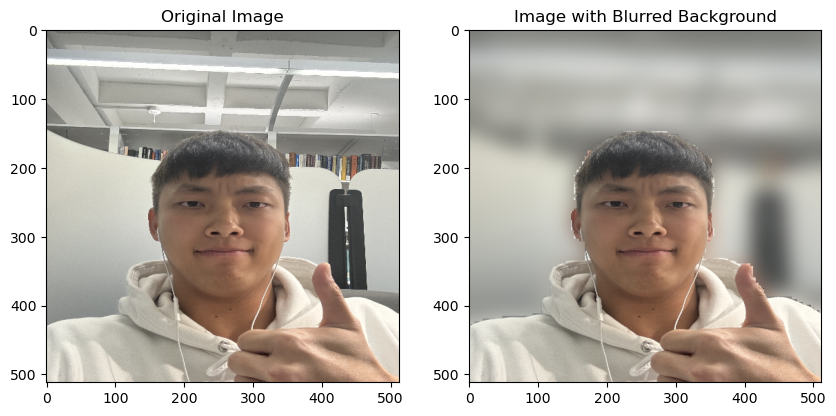

In [56]:
# Apply the function
blurred_background_image = [gaussian_blur_background(original_img, segmentation_masks[0], sigma=15)]

# Visualize comparison of original image and blurred image
visualize_mask(original_img, blurred_background_image, num_img=2, mask_names=['Image with Blurred Background'])

# 3-3: Depth Dstimation Model

## Load Intended Model
Both models below work properly.

### depth-anything/Depth-Anything-V2-Large-hf

In [57]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")

### Intel/dpt-large

In [58]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

# processor = AutoImageProcessor.from_pretrained("Intel/dpt-large")
model = AutoModelForDepthEstimation.from_pretrained("Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Perfrom Depth Estimation

In [59]:
# Get the output of pretrained model
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    predicted_depth = output.predicted_depth

# The output of depth_prediction model is a DepthEstimatorOutput class
# print(type(output))

In [60]:
# Get image from local directory
# image = Image.open(img_path)

# Fetch the image from the URL
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful
image = Image.open(BytesIO(response.content))

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()

# Normalize the ouput to different range (0~15 and 0~255 in this case)
range_1 = 15
depth_mask_1 = (output * range_1 / np.max(output)).astype("uint8")
range_2 =255
depth_mask_2 = (output * range_2 / np.max(output)).astype("uint8")

depth_masks = [depth_mask_1, depth_mask_2]

## Visualize the Result

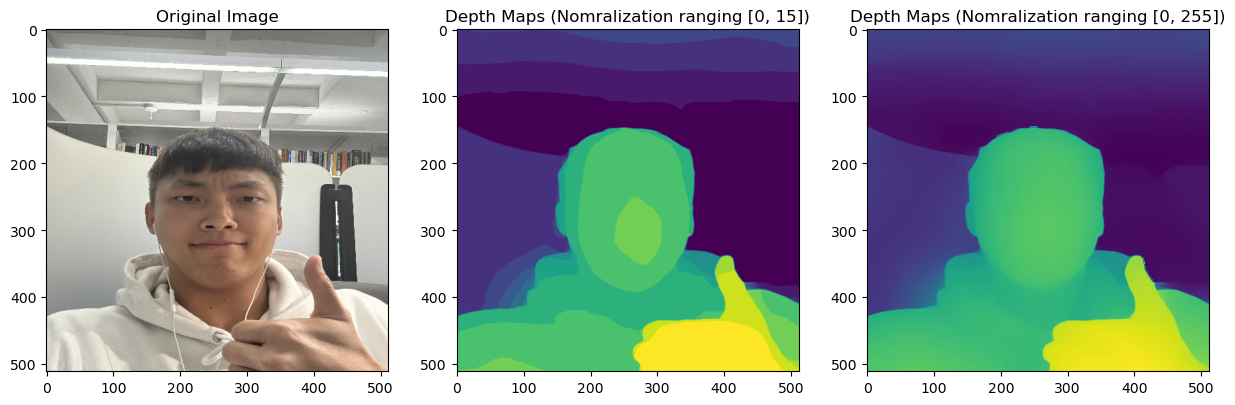

In [61]:
masks_names = [f'Depth Maps (Nomralization ranging [0, {range_1}])', f'Depth Maps (Nomralization ranging [0, {range_2}])']

visualize_mask(original_img, depth_masks, num_img=len(masks_names)+1, mask_names=masks_names)

# 3-4: Implement Gaussian Blur according to different depth

In [62]:
def depth_gaussian_blur(original_image, depth_map, normalization_range):

    # Resize the depth map to match the original image dimensions
    normalized_depth = cv2.resize(depth_map, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Initialize the result image (the same size of original image)
    result_image = np.zeros_like(original_image)

    for depth in range(normalization_range+1):

        # More depth -> more blur
        sigma = normalization_range-depth

        current_mask = (normalized_depth >= depth) & (normalized_depth < depth+1)
        current_mask = current_mask[..., None]

        # Get the region to blur
        region_to_blur = np.where(current_mask, original_image, original_image)

        # sigma cannot be zero (set to small value whn sgma=0)
        if sigma>0:
            # Apply Gaussian blur to the intended region of image
            blurred_region = cv2.GaussianBlur(region_to_blur, (0, 0), sigmaX=sigma)
        else:
            blurred_region = cv2.GaussianBlur(region_to_blur, (0, 0), sigmaX=0.00001)

    # Combine the blurred region into the result image
        result_image = np.where(current_mask, blurred_region, result_image)

    return result_image

## Visualize the result

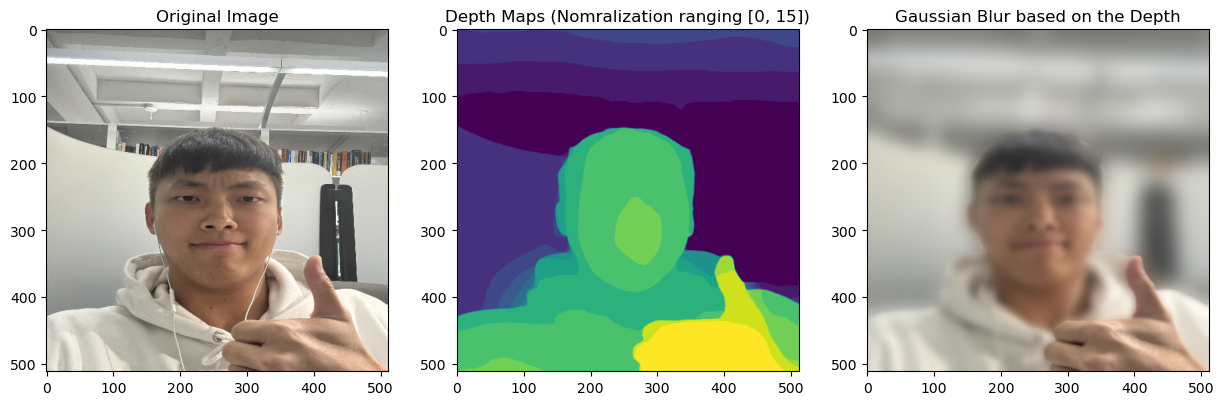

In [63]:
depth_based_gaussian = depth_gaussian_blur(original_img, depth_mask_1, normalization_range=range_1)

masks = [depth_mask_1, depth_based_gaussian]
masks_names = [f'Depth Maps (Nomralization ranging [0, {range_1}])', 'Gaussian Blur based on the Depth']

visualize_mask(original_img, masks, num_img=len(masks)+1, mask_names=masks_names)